# Insurance Pricing Model: Importing Data and Exploratory Data Analysis

Before I begin instructing a model, I need to get a dataset, explore it with some basic exploratory analysis and prepare it for use as a model input.

This is intended for an audience with at least a basic understanding of Python tools (numpy, pandas, matplotlib, sklearn), linear modeling, machine learning and insurance concepts.

# Data Source

I will utilize the public dataset commonly called the "French Motor Third-Party Liability Claims" data. It is available on the OpenML website at the links below. Note that frequency and severity data are packaged into two separate datasets. I'll need to join them together into a single dataset to work with.

- [Frequency](https://www.openml.org/d/41214)
- [Severity](https://www.openml.org/d/41215)

# Packages & Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from utils import *

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option("display.max_columns", None)

# Import Data

In [2]:
df_raw_freq = fetch_openml(data_id=41214, as_frame=True).frame
df_raw_sev = fetch_openml(data_id=41215, as_frame=True).frame

print(f"Frequency dataset is unique on IDpol? {df_raw_freq['IDpol'].is_unique}")
print(f"Severity dataset is unique on IDpol? {df_raw_sev['IDpol'].is_unique}")

Frequency dataset is unique on IDpol? True
Severity dataset is unique on IDpol? False


The frequency dataset is 1 row per IDPol.

The severity dataset is NOT 1 row per IDPol. The severity dataset has a row for each claim that each IDPol had. 

My goal is to have a dataset that is 1 row per IDPol and the total loss amounts that occurred during that IDPol's exposure period. Therefore, I'll need to sum up all the claims for each IDPol. However, once I do that I lose the claim-level information and any adjustments I'd like to make to those claim amounts, such as capping.

In a different notebook, I plan to do an experiment considering several large loss capping scenarios. This won't make much sense right now, but I'll create many capping scenarios (even crazy scenarios) before aggregating and joining to the frequency dataset.

After joining, I'll define target variable fields.

In [3]:
df_sev = df_raw_sev.copy()

# capping levels I want to study
caps = [1, 10_000, 25_000, 50_000, 100_000, 200_000, 300_000,
        400_000, 500_000, 600_000, 700_000, 800_000, 900_000,
        1_000_000, 2_000_000]

# create a new capped loss amount field for each cap
for cap in caps:
  df_sev[f"ClaimAmount_capped_{fmt_cap(cap)}"] = df_sev["ClaimAmount"].clip(upper=cap)

# aggregate
df_sev = df_sev.groupby("IDpol").sum().reset_index()

# join frequency data
df = df_raw_freq.merge(df_sev, on="IDpol", how="left")

# fill no-claim ClaimAmounts with 0s
mask = df.columns.str.contains(r"^ClaimAmount", case=False)
df.loc[:, mask] = df.loc[:, mask].fillna(0)

# define target variables
df["frequency"] = np.where(df["Exposure"] == 0, 0, df["ClaimNb"] / df["Exposure"])
df["severity_uncapped"] = np.where(df["ClaimNb"] == 0, 0, df["ClaimAmount"] / df["ClaimNb"])
for cap in caps:
    df[f"severity_capped_{fmt_cap(cap)}"] = np.where(df["ClaimNb"] == 0, 0, df[f"ClaimAmount_capped_{fmt_cap(cap)}"] / df["ClaimNb"])
df["pure_premium_uncapped"] = np.where(df["Exposure"] == 0, 0, df["ClaimAmount"] / df["Exposure"])
for cap in caps:
    df[f"pure_premium_capped_{fmt_cap(cap)}"] = np.where(df["Exposure"] == 0, 0, df[f"ClaimAmount_capped_{fmt_cap(cap)}"] / df["Exposure"])

Basic metadata and information printouts.

In [4]:
print(f"The shape of the dataset is: {df.shape}.")
print('-'*100)
npreview = 5
print(f"Top {npreview} rows:")
display(df.head(npreview))

The shape of the dataset is: (678013, 61).
----------------------------------------------------------------------------------------------------
Top 5 rows:


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmount_capped_1,ClaimAmount_capped_10K,ClaimAmount_capped_25K,ClaimAmount_capped_50K,ClaimAmount_capped_100K,ClaimAmount_capped_200K,ClaimAmount_capped_300K,ClaimAmount_capped_400K,ClaimAmount_capped_500K,ClaimAmount_capped_600K,ClaimAmount_capped_700K,ClaimAmount_capped_800K,ClaimAmount_capped_900K,ClaimAmount_capped_1MIL,ClaimAmount_capped_2MIL,frequency,severity_uncapped,severity_capped_1,severity_capped_10K,severity_capped_25K,severity_capped_50K,severity_capped_100K,severity_capped_200K,severity_capped_300K,severity_capped_400K,severity_capped_500K,severity_capped_600K,severity_capped_700K,severity_capped_800K,severity_capped_900K,severity_capped_1MIL,severity_capped_2MIL,pure_premium_uncapped,pure_premium_capped_1,pure_premium_capped_10K,pure_premium_capped_25K,pure_premium_capped_50K,pure_premium_capped_100K,pure_premium_capped_200K,pure_premium_capped_300K,pure_premium_capped_400K,pure_premium_capped_500K,pure_premium_capped_600K,pure_premium_capped_700K,pure_premium_capped_800K,pure_premium_capped_900K,pure_premium_capped_1MIL,pure_premium_capped_2MIL
0,1.00,1,0.10,D,5,0,55,50,B12,'Regular',1217,R82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,3.00,1,0.77,D,5,0,55,50,B12,'Regular',1217,R82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,5.00,1,0.75,B,6,2,52,50,B12,'Diesel',54,R22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,10.00,1,0.09,B,7,0,46,50,B12,'Diesel',76,R72,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,11.00,1,0.84,B,7,0,46,50,B12,'Diesel',76,R72,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 61 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   IDpol                     678013 non-null  float64 
 1   ClaimNb                   678013 non-null  int64   
 2   Exposure                  678013 non-null  float64 
 3   Area                      678013 non-null  category
 4   VehPower                  678013 non-null  int64   
 5   VehAge                    678013 non-null  int64   
 6   DrivAge                   678013 non-null  int64   
 7   BonusMalus                678013 non-null  int64   
 8   VehBrand                  678013 non-null  category
 9   VehGas                    678013 non-null  object  
 10  Density                   678013 non-null  int64   
 11  Region                    678013 non-null  category
 12  ClaimAmount               678013 non-null  float64 
 13  ClaimAmount_capped_1      678

In [6]:
df.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,ClaimAmount_capped_1,ClaimAmount_capped_10K,ClaimAmount_capped_25K,ClaimAmount_capped_50K,ClaimAmount_capped_100K,ClaimAmount_capped_200K,ClaimAmount_capped_300K,ClaimAmount_capped_400K,ClaimAmount_capped_500K,ClaimAmount_capped_600K,ClaimAmount_capped_700K,ClaimAmount_capped_800K,ClaimAmount_capped_900K,ClaimAmount_capped_1MIL,ClaimAmount_capped_2MIL,frequency,severity_uncapped,severity_capped_1,severity_capped_10K,severity_capped_25K,severity_capped_50K,severity_capped_100K,severity_capped_200K,severity_capped_300K,severity_capped_400K,severity_capped_500K,severity_capped_600K,severity_capped_700K,severity_capped_800K,severity_capped_900K,severity_capped_1MIL,severity_capped_2MIL,pure_premium_uncapped,pure_premium_capped_1,pure_premium_capped_10K,pure_premium_capped_25K,pure_premium_capped_50K,pure_premium_capped_100K,pure_premium_capped_200K,pure_premium_capped_300K,pure_premium_capped_400K,pure_premium_capped_500K,pure_premium_capped_600K,pure_premium_capped_700K,pure_premium_capped_800K,pure_premium_capped_900K,pure_premium_capped_1MIL,pure_premium_capped_2MIL
count,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00,678013.00
mean,2621856.92,0.05,0.53,6.45,7.04,45.50,59.76,1792.42,88.36,0.04,57.84,63.89,68.42,72.72,76.99,78.74,79.58,80.17,80.76,81.35,81.90,82.34,82.79,85.30,0.26,81.72,0.04,54.07,59.65,63.84,67.74,71.56,73.06,73.68,74.20,74.71,75.23,75.71,76.08,76.45,78.66,383.26,0.12,221.03,256.15,280.98,309.05,341.38,347.26,350.42,352.06,353.69,355.33,356.92,358.40,359.87,369.35
std,1641782.75,0.24,0.36,2.05,5.67,14.14,15.64,3958.65,5822.45,0.21,467.29,648.62,866.84,1171.68,1616.48,1864.09,2015.33,2143.07,2289.53,2451.35,2614.36,2754.52,2903.15,3912.12,4.59,5576.57,0.19,423.29,595.16,803.30,1085.11,1487.45,1699.97,1805.97,1921.70,2054.32,2200.77,2345.84,2463.16,2587.99,3535.78,36820.70,2.02,7465.36,10226.21,12849.43,18064.76,28039.44,28353.01,28587.24,28673.12,28777.74,28900.89,29041.10,29195.40,29366.89,31169.57
min,1.00,0.00,0.00,4.00,0.00,18.00,50.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1157951.00,0.00,0.18,5.00,2.00,34.00,50.00,92.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2272152.00,0.00,0.49,6.00,6.00,44.00,50.00,393.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,4046274.00,0.00,0.99,7.00,11.00,55.00,64.00,1658.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,6114330.00,16.00,2.01,15.00,100.00,100.00,230.00,27000.00,4075400.56,16.00,35529.37,40600.00,65600.00,115600.00,213823.26,313823.26,401128.12,501128.12,601128.12,701128.12,801128.12,901128.12,1001128.12,2000000.00,732.00,4075400.56,1.00,10000.00,25000.00,50000.00,10

Some notes from the above printouts:

- There is a VERY large loss on a VERY small exposure amount causing the max pure premium value to come in over $18mil. This most definitely qualifies as an uncommon large loss and most likely a problematic outlier. As mentioned above, I have some ideas on how to handle this that'll be covered in a later notebook.
- There are 0-exposure periods. I'll likely need to do a minimum exposure floor for observations to exclude.
- No missing data! Whoo-hoo!

Data definitions:
- IDPol: Policy ID, used to link to severity data set
- ClaimNb: number of claims that occurred during exposure period
- Exposure: Period of exposure for a policy in year(s)
- VehPower:  Car power, in categorical format
- VehAge: Car age, in continuous value format
- DrivAge: Driver's age in years, in continuous value format
- BonusMalus: Bonus / Malus rating, <100 means bonus, >100 means malus, in continous value format
- VehBrand: Car brand, in categorical format
- VechGas: Fuel type, in categorical format
- Area: Density rating of the area car driver lives in, in categorical format
- Density: Density rating, number of inhabitants per km^2, in continous value format
- Region: Policy region in France, in categorical format
- ClaimAmount: Total incurred loss for all claims during exposure period
- frequency: ClaimNb / Exposure
- severity: ClaimAmount / ClaimNb
- pure_premium: ClaimAmount / Exposure
- ClaimAmount, severity and pure_premium "capped": Various fields using ClaimAmount with individual claims from the sev dataset individually capped at many thresholds

# 1-Way Exploratory Data Analysis

In this section, I will explore 1-dimensional graphs comboplots for each variables compared to the target. In particular, uncapped pure premium. This is the main goal of pricing modeling. There *are* other notebooks in this project that will use Frequency and Severity, I'll just focus on Pure Premium for now. Also, I already discussed above fully uncapped is problematic because of the large loss, but nonetheless, I'll focus on it for now.

The main things I am looking for:

1. Generally the shapes of relationship with the target. I want some strong pattern. It doesn't necessarily have to be monotonically increasing or decreasing, but when I see a more advanced quadratic or cubic, etc. pattern I have to "believe" it.
2. Skewness and thinness in extreme values. This is an indication I'll need to do some sort of transformation or capping/flooring on the numeric field.
3. Notice that thinner buckets usually have more variance and thus the mean is not as reliable, but it is not always the thin buckets that do this.

1-way graphs are NOT really to be used for variable selection, but they can be an early variable selection technique when data quality is low. For example, just because I see a flat relationship to the target variable here does NOT mean the variable won't be useful to a model. It may be the case that it is necessary for an interaction with another variable. It's best to rely on more careful variable selection methods before tossing variables out this early. However, if a variable is missing massive amounts of values or if individual categories in a categorical variable are tiny and unreliable, this can help me toss the variable or collapse the bucket.

In [7]:
X_cols = [
  'Area',
  'VehPower',
  'VehAge',
  'DrivAge',
  'BonusMalus',
  'VehBrand',
  'VehGas',
  'Density',
  'Region'
]

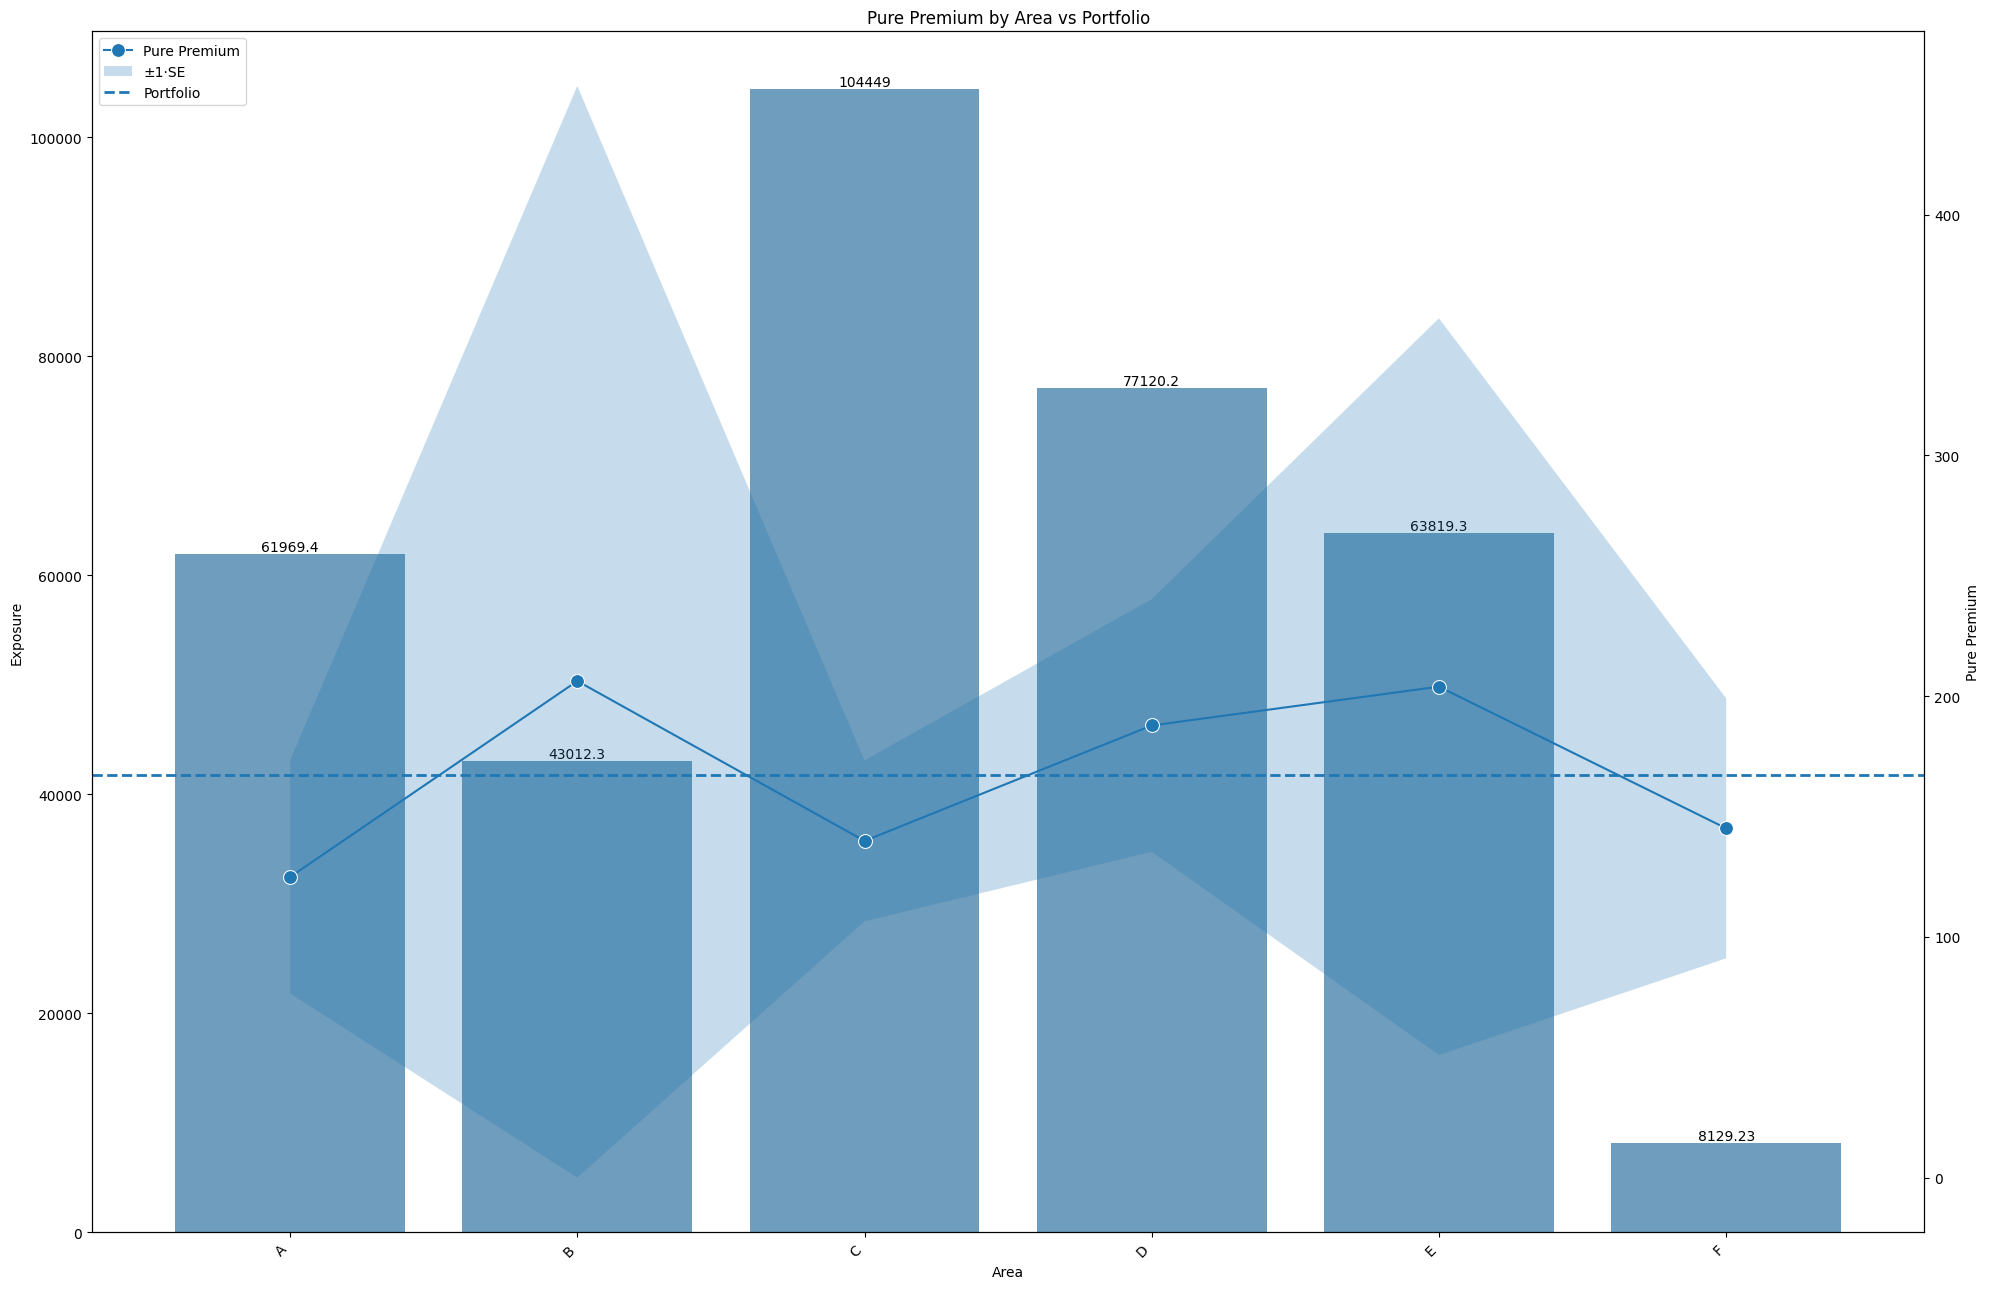

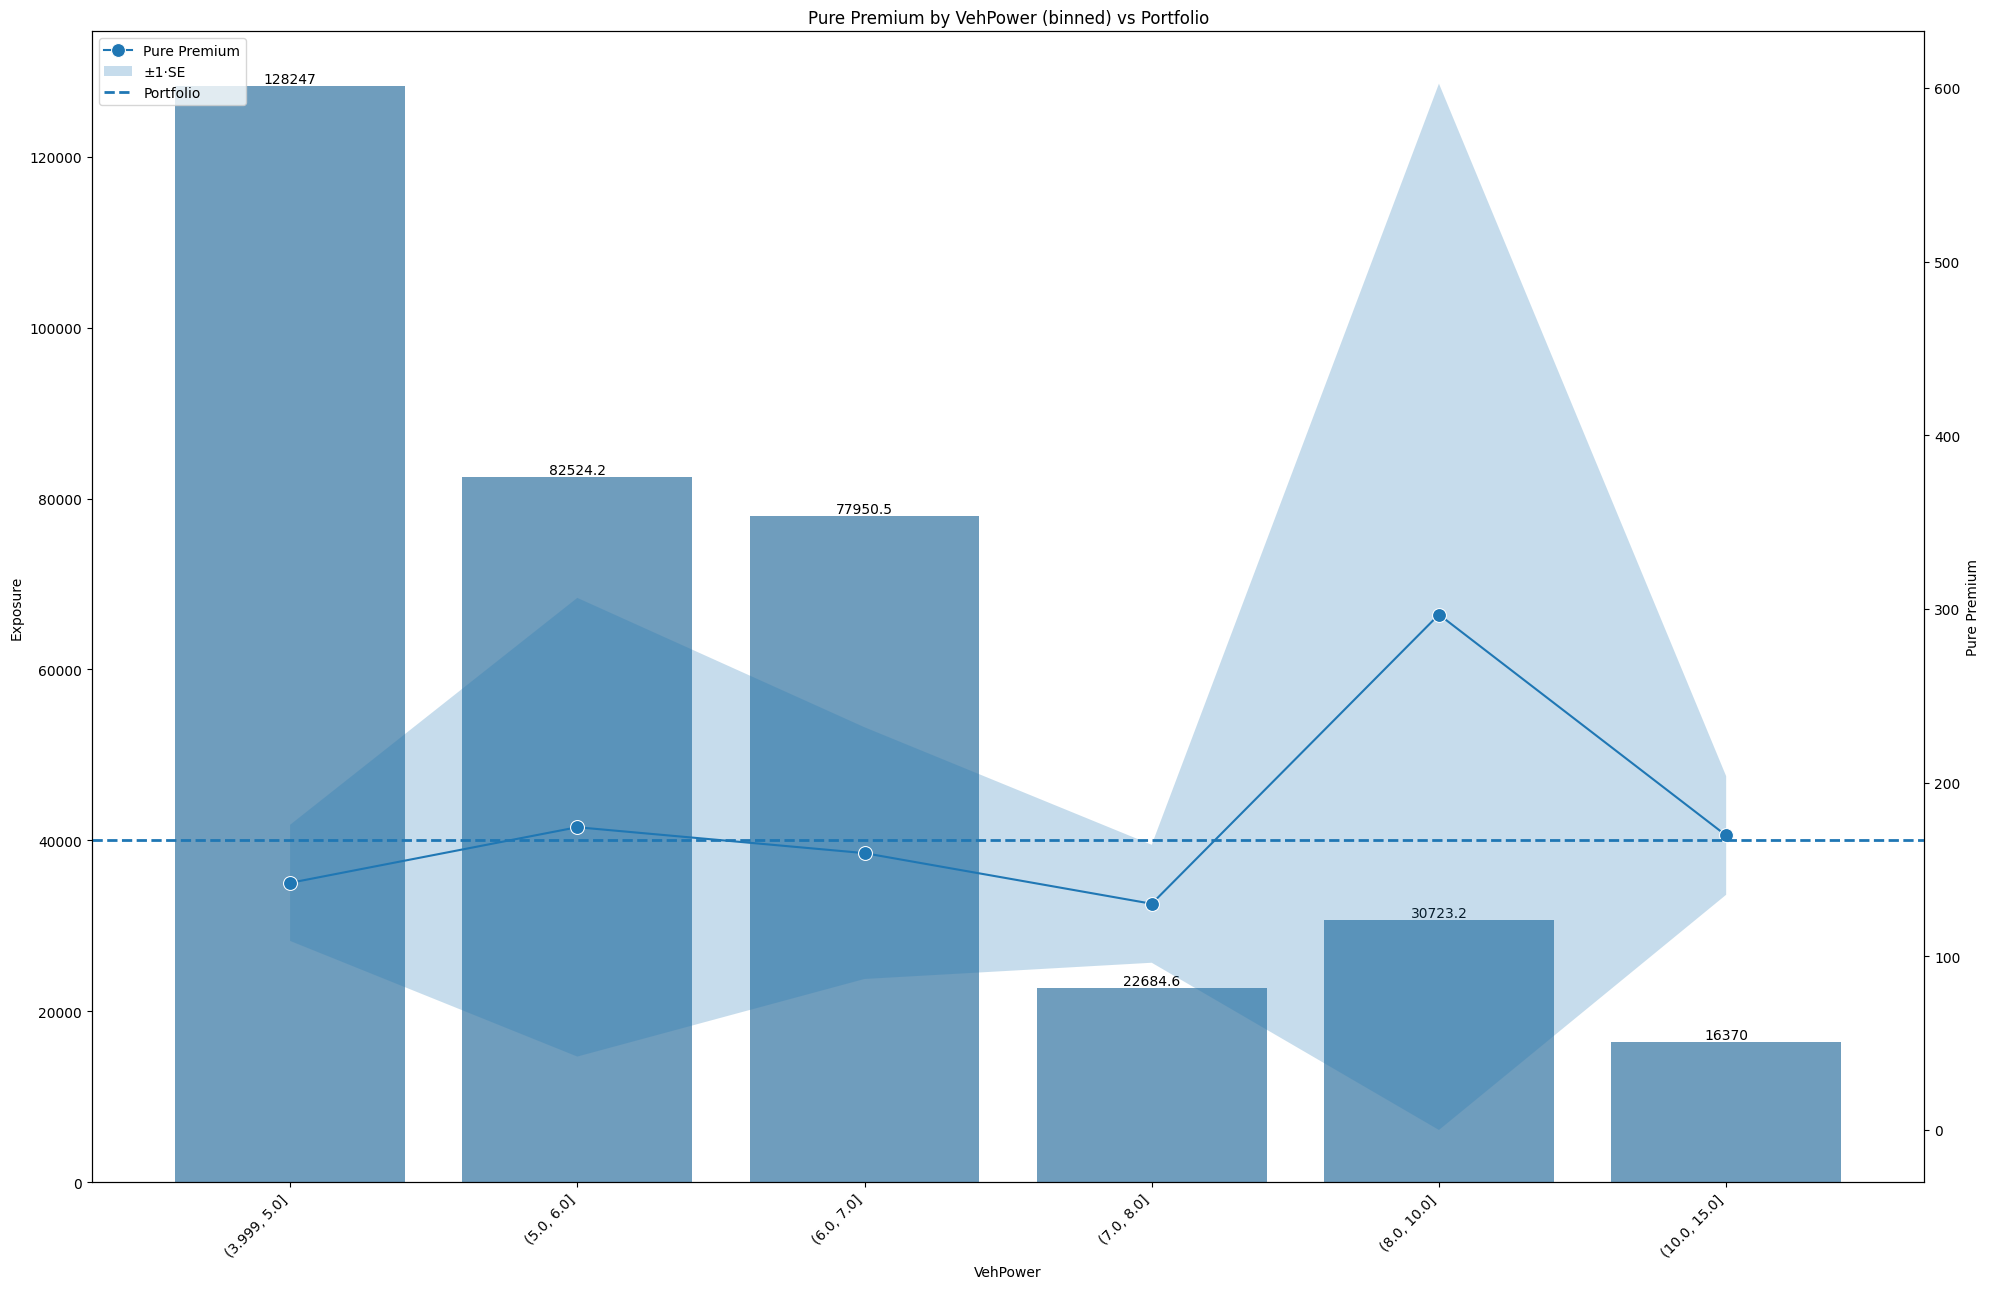

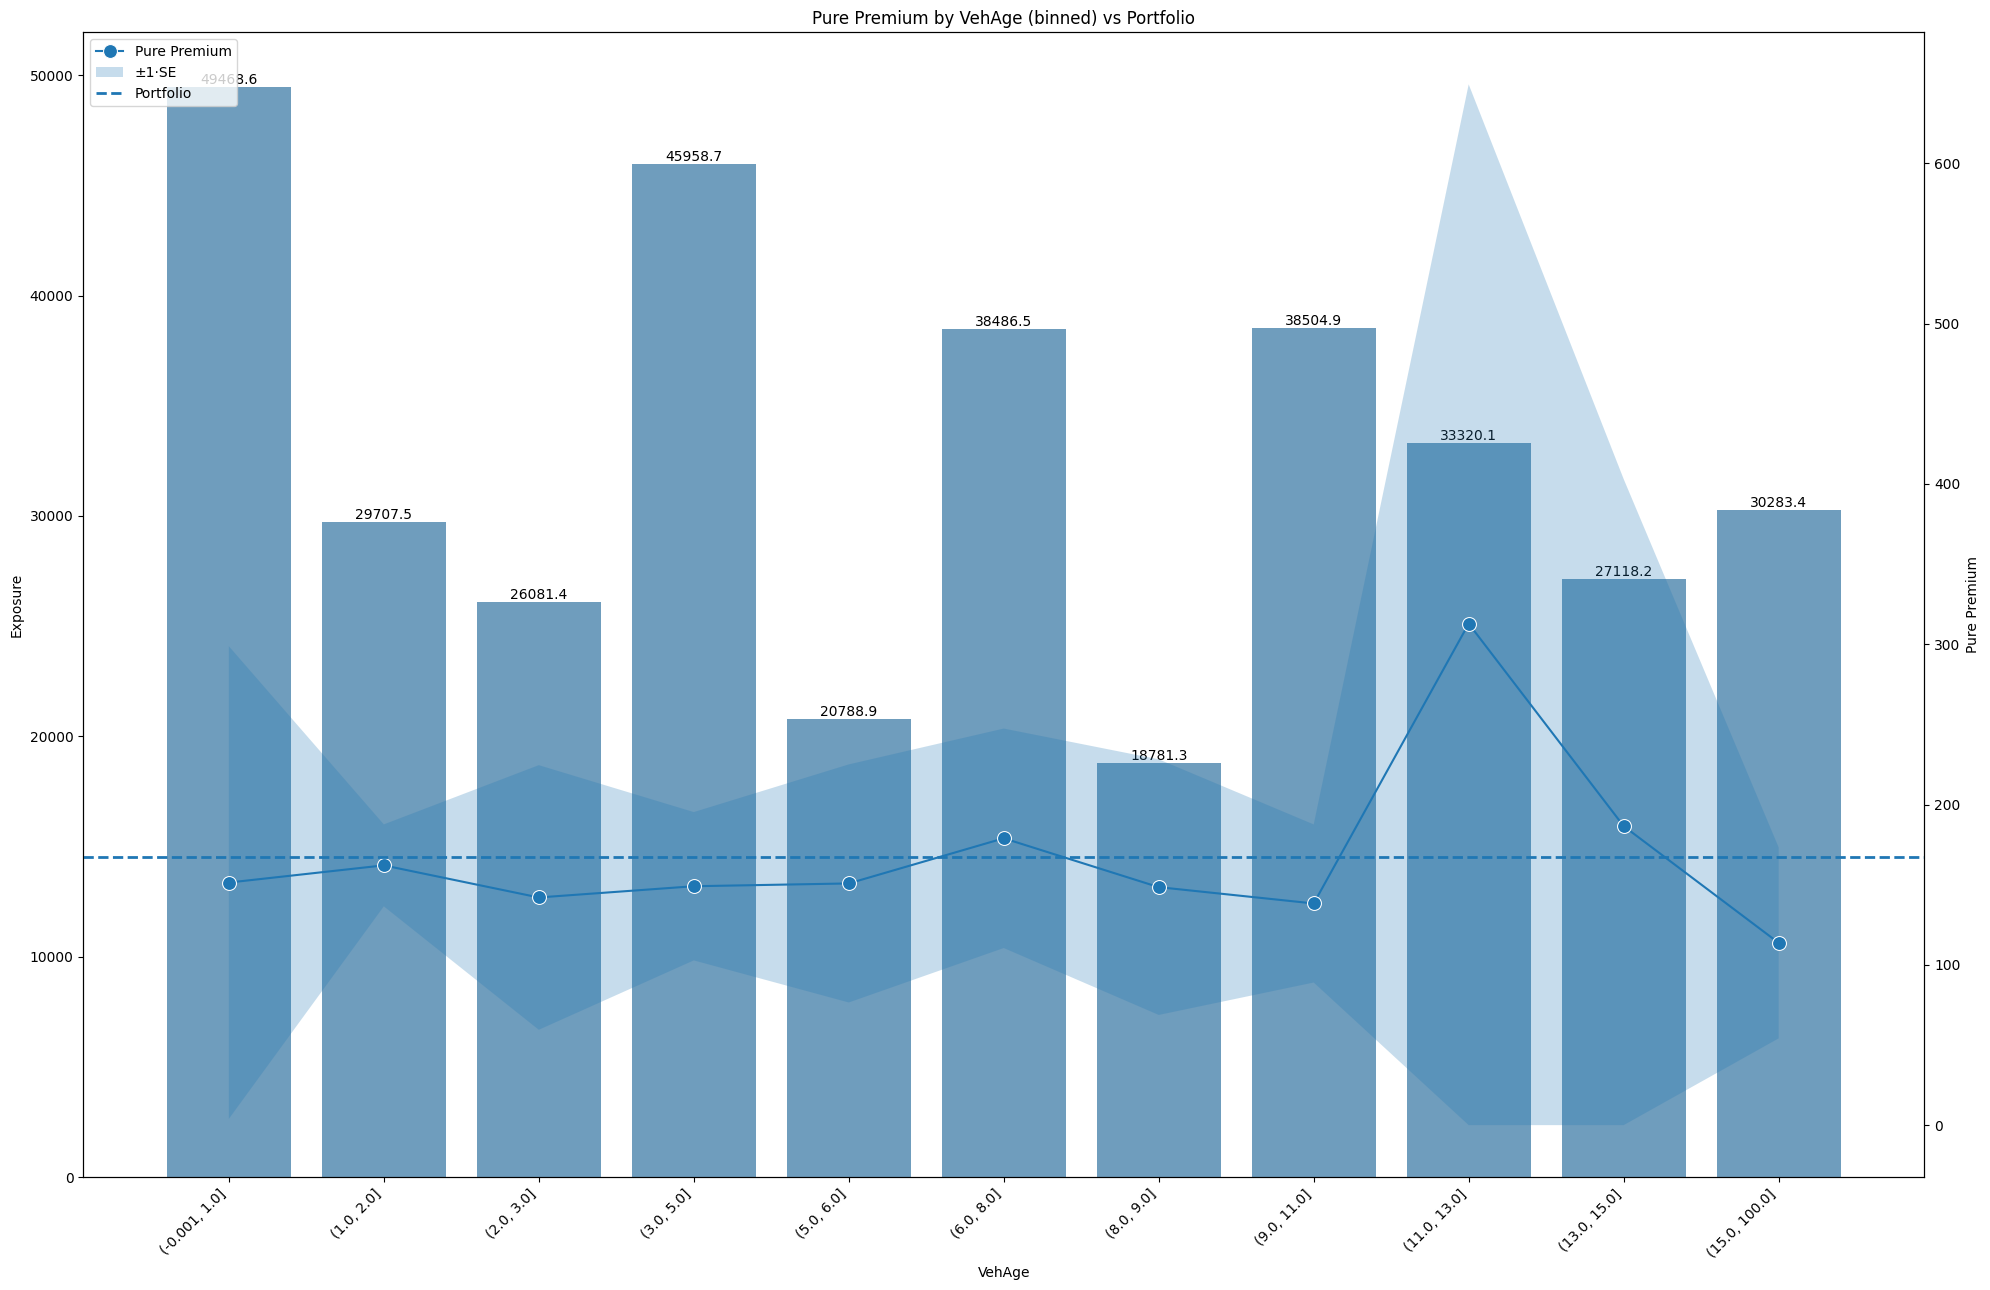

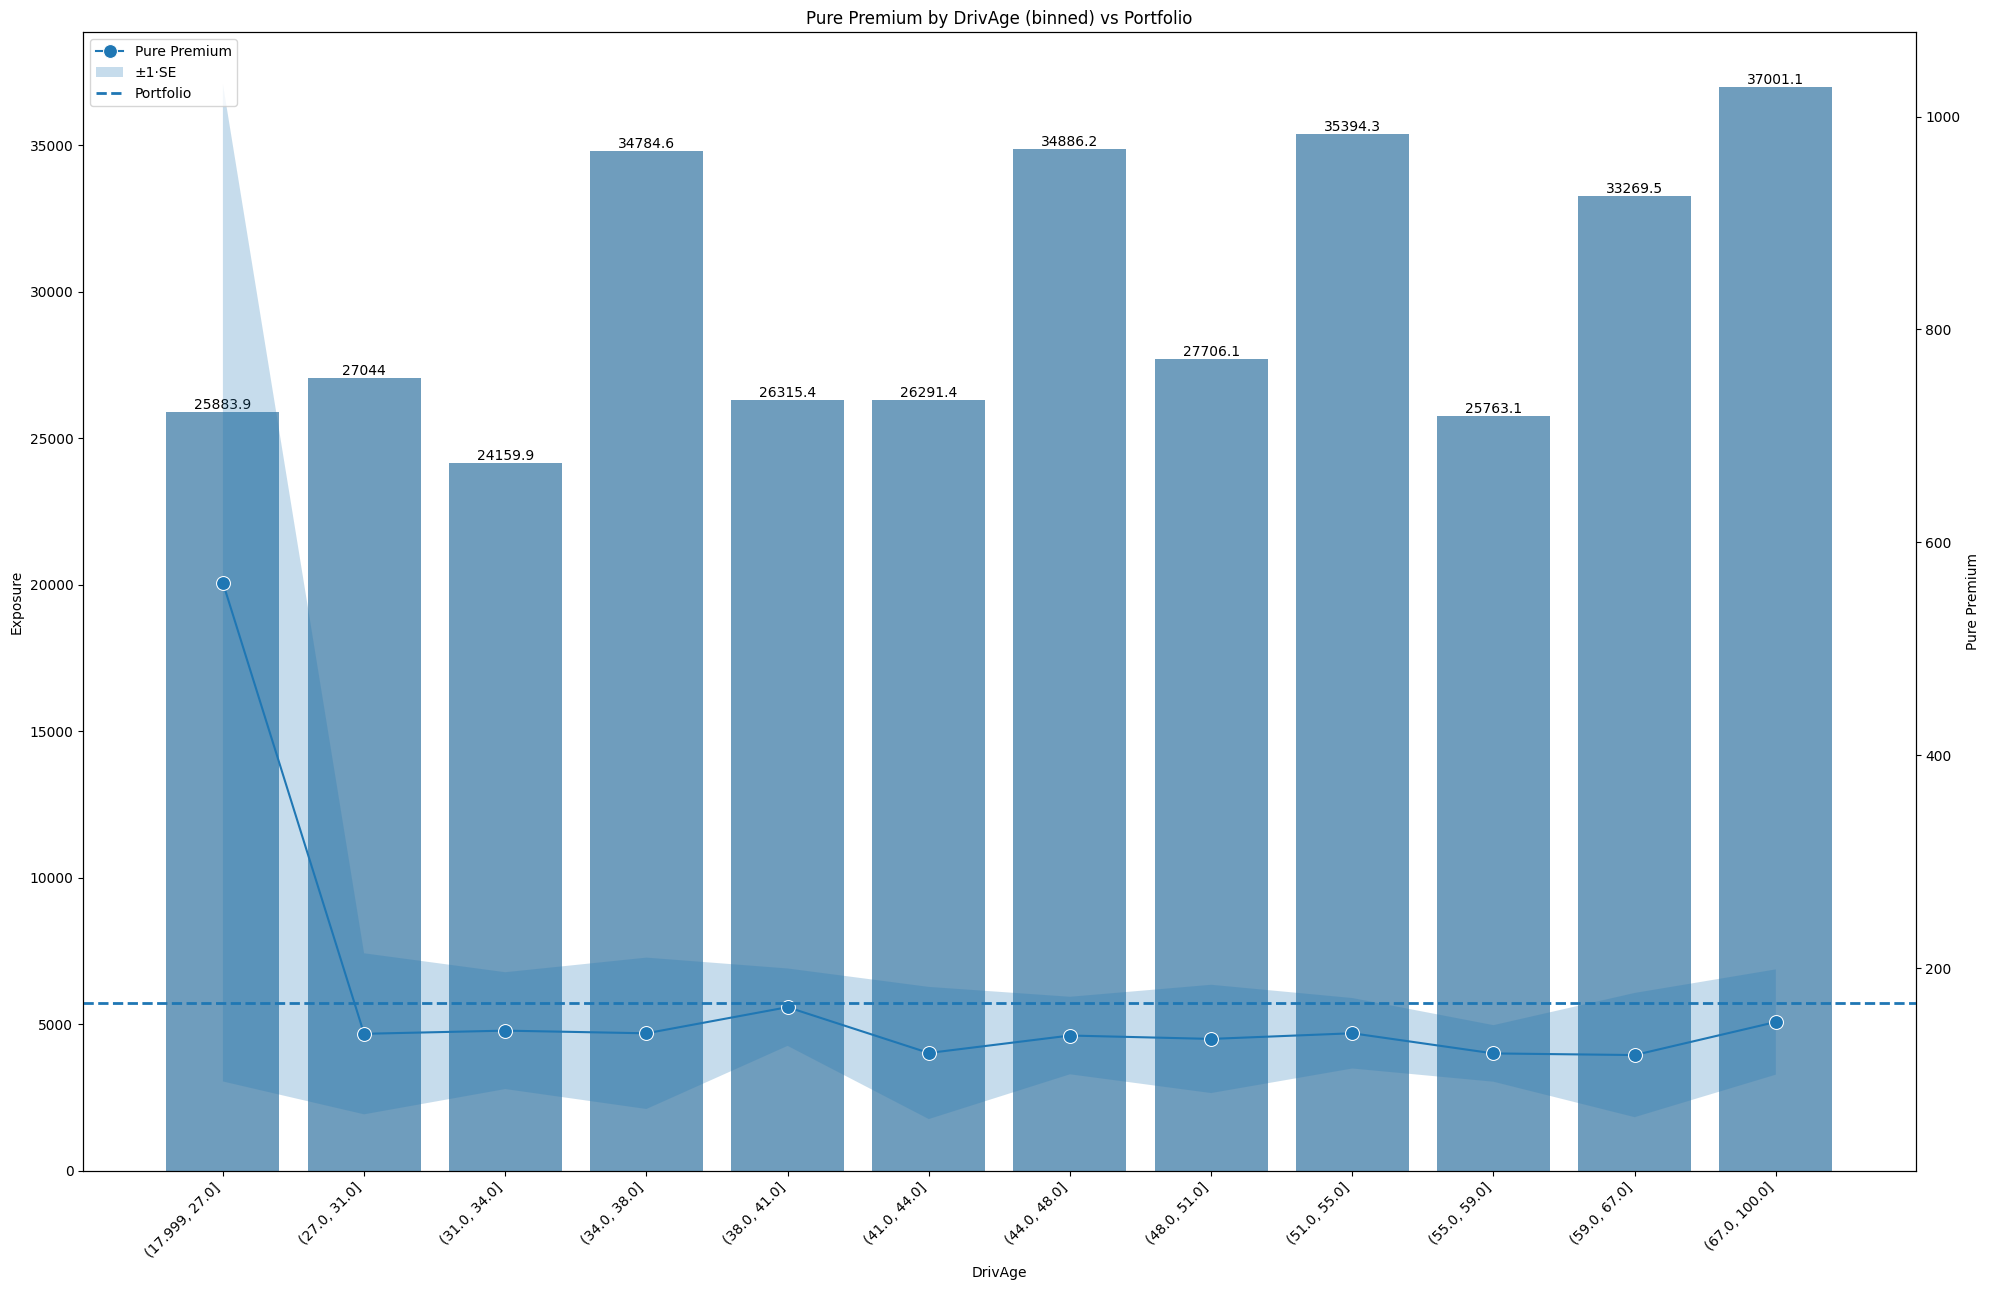

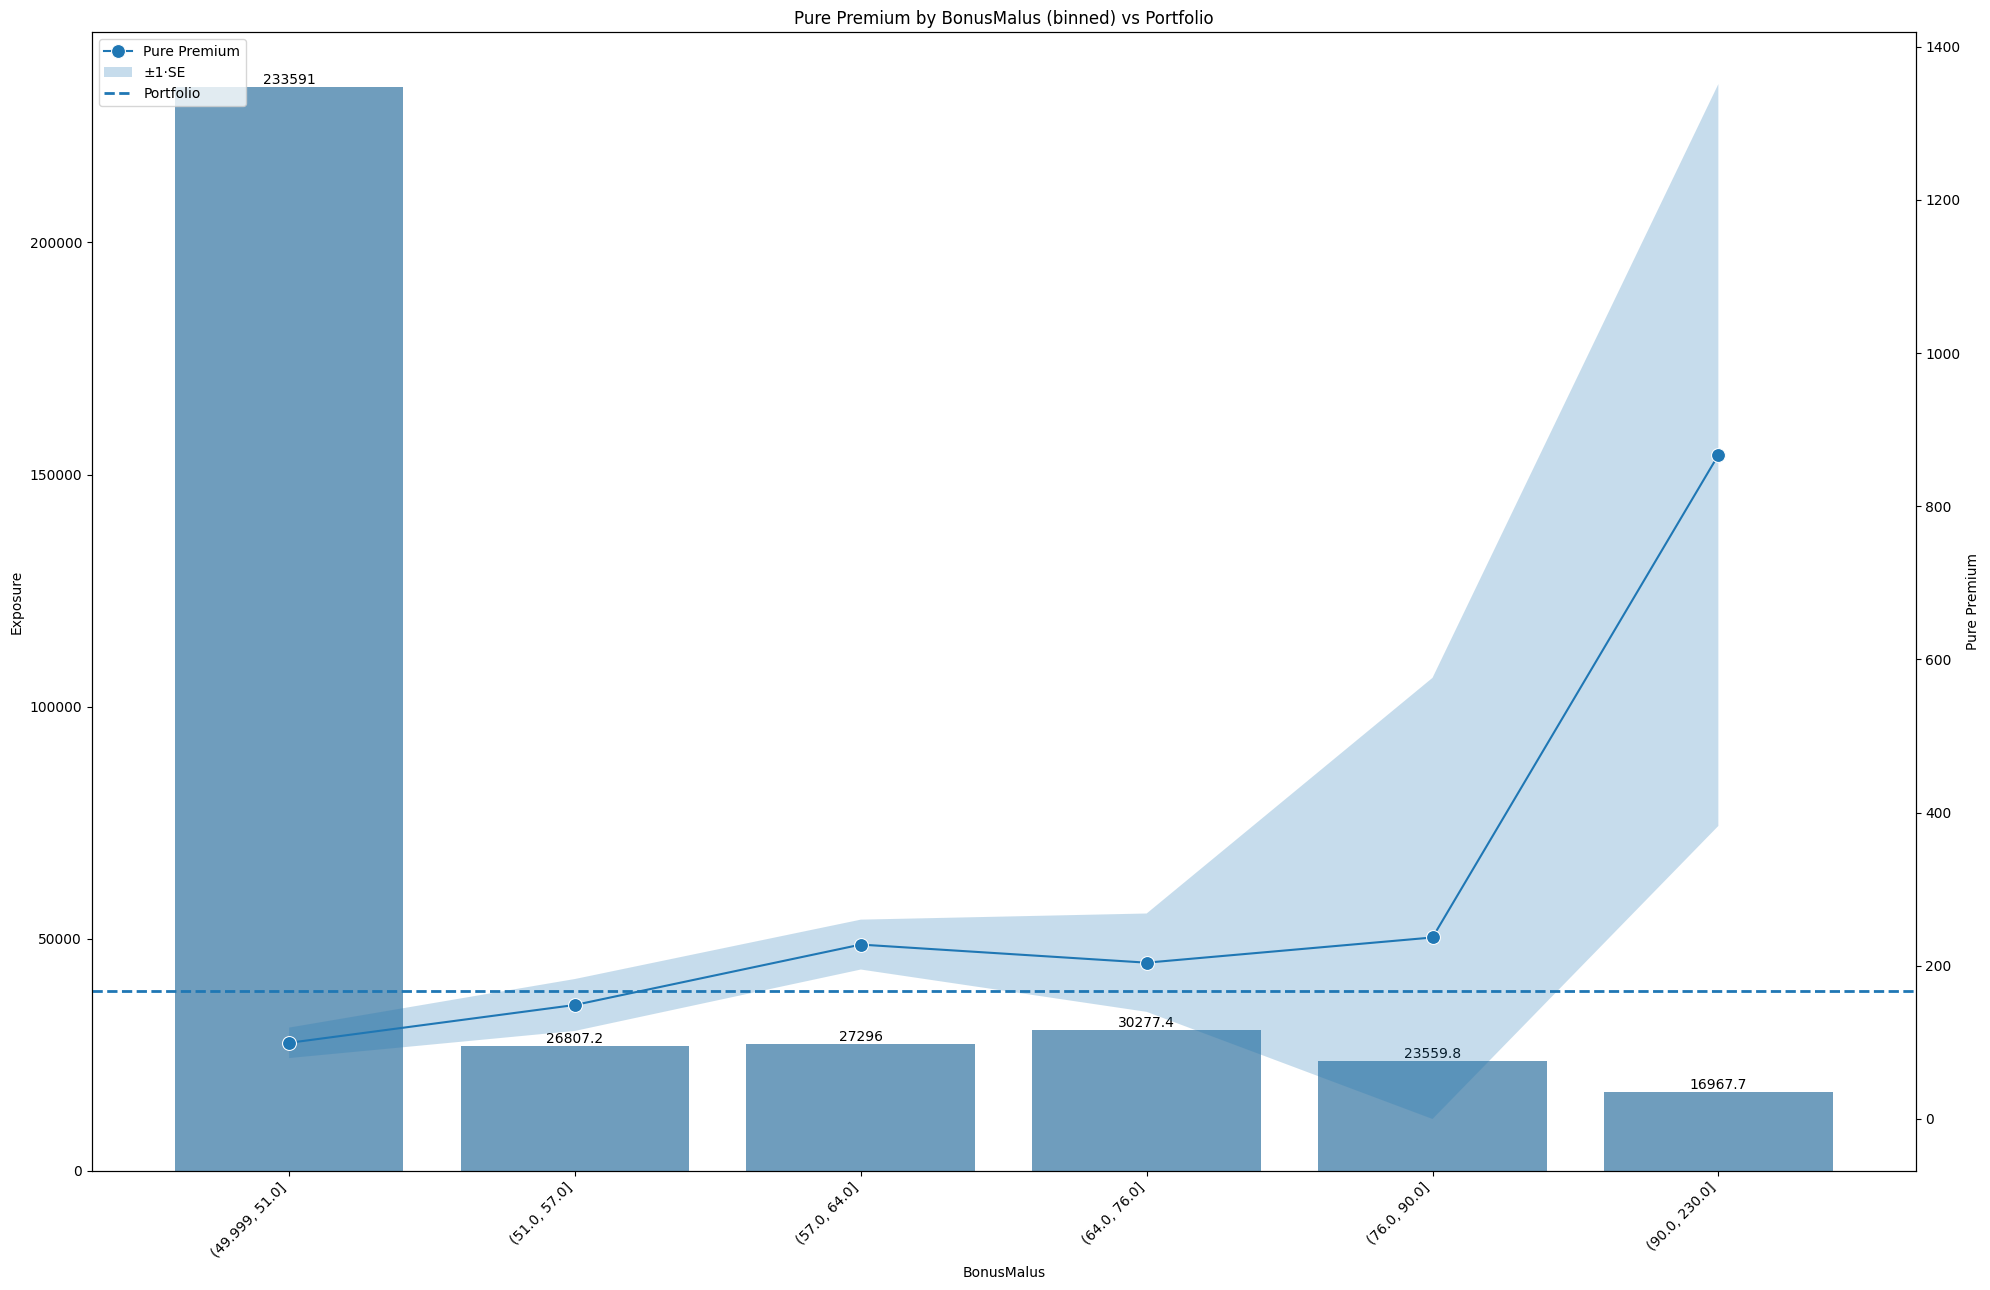

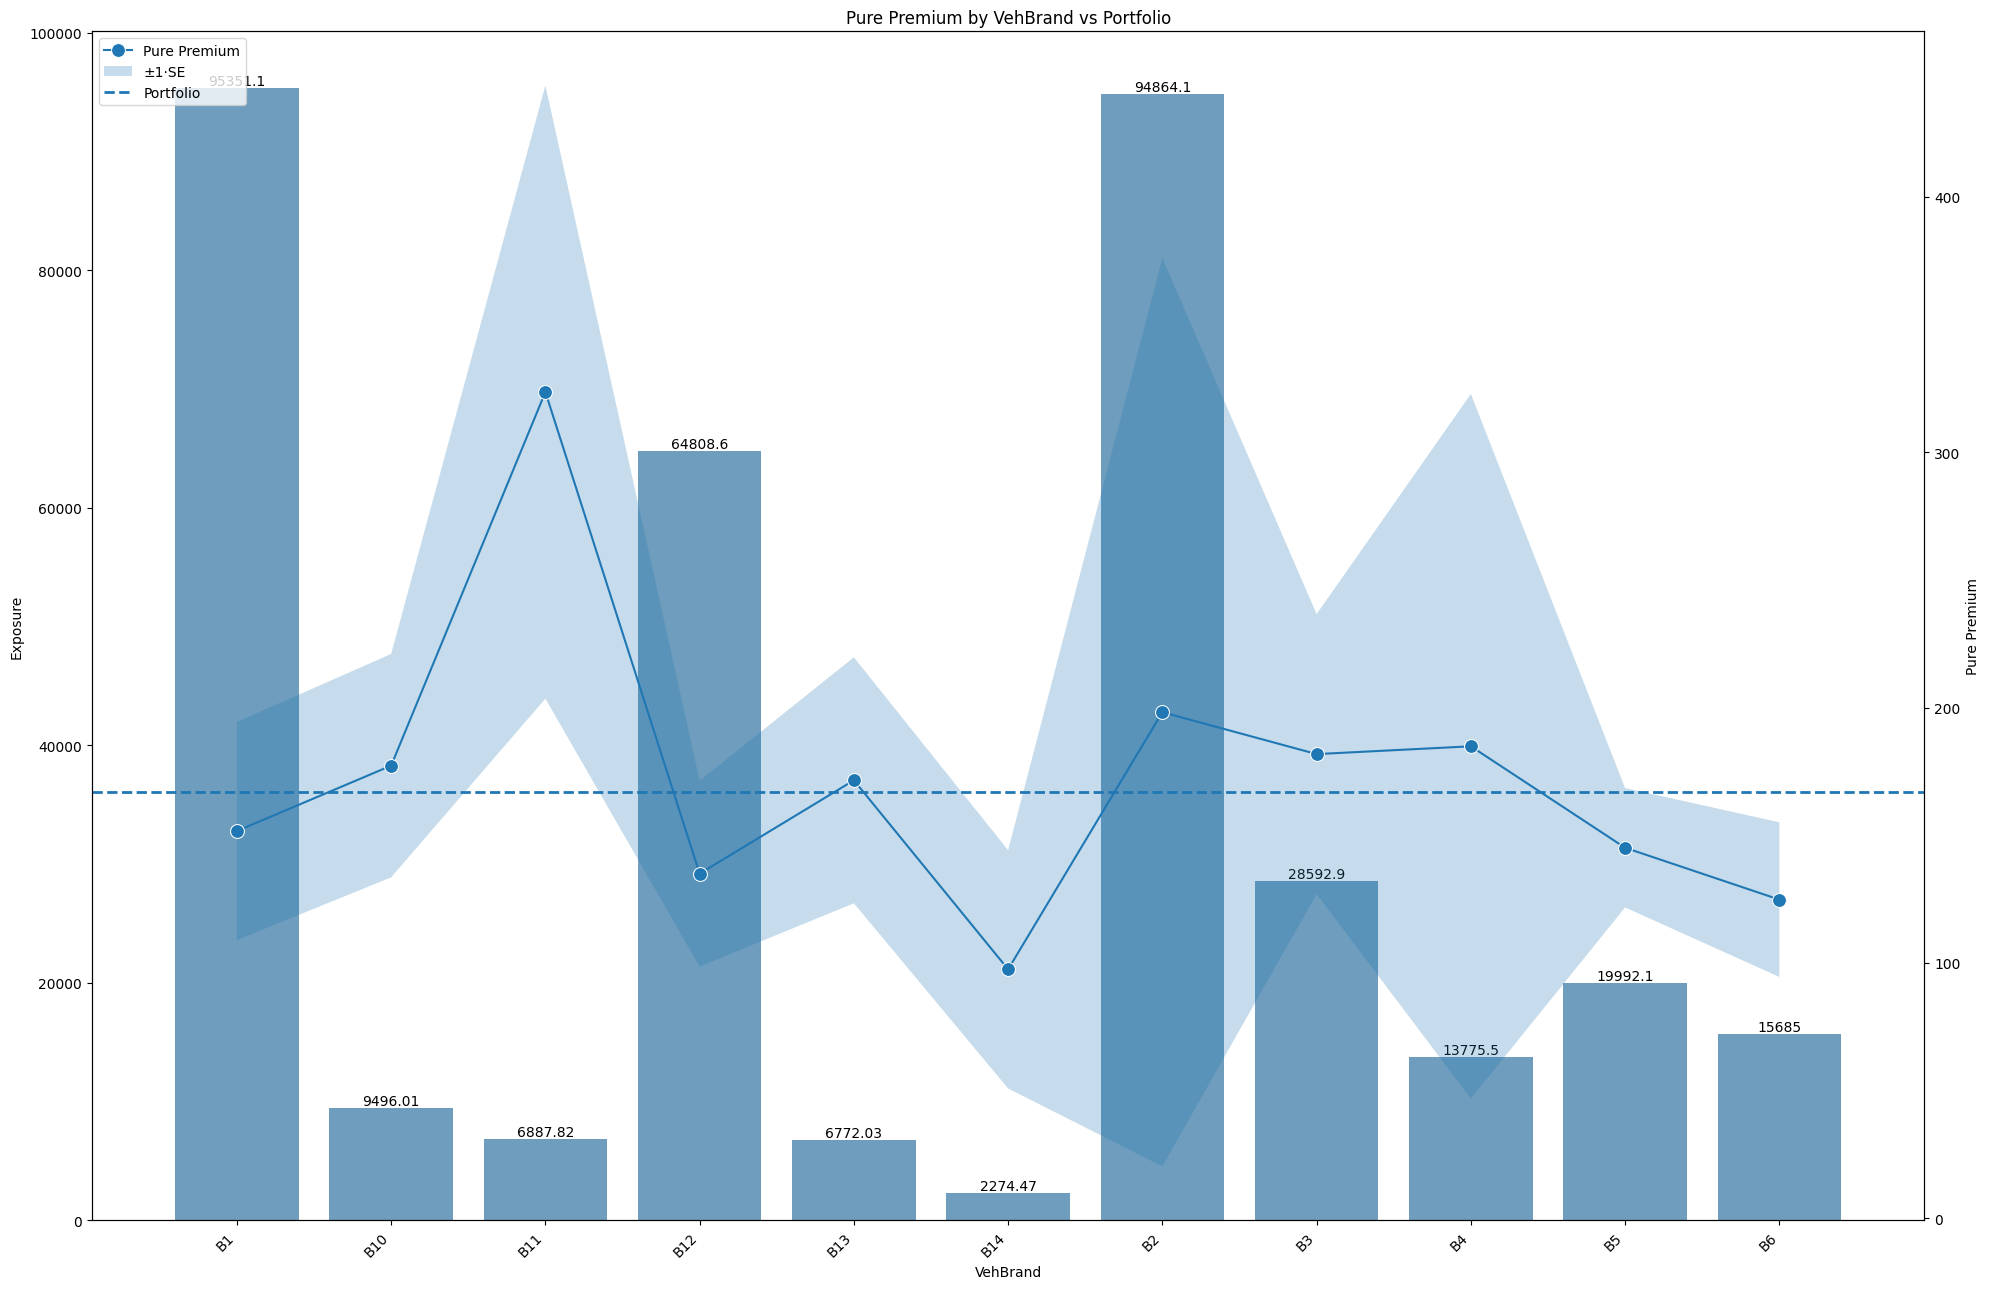

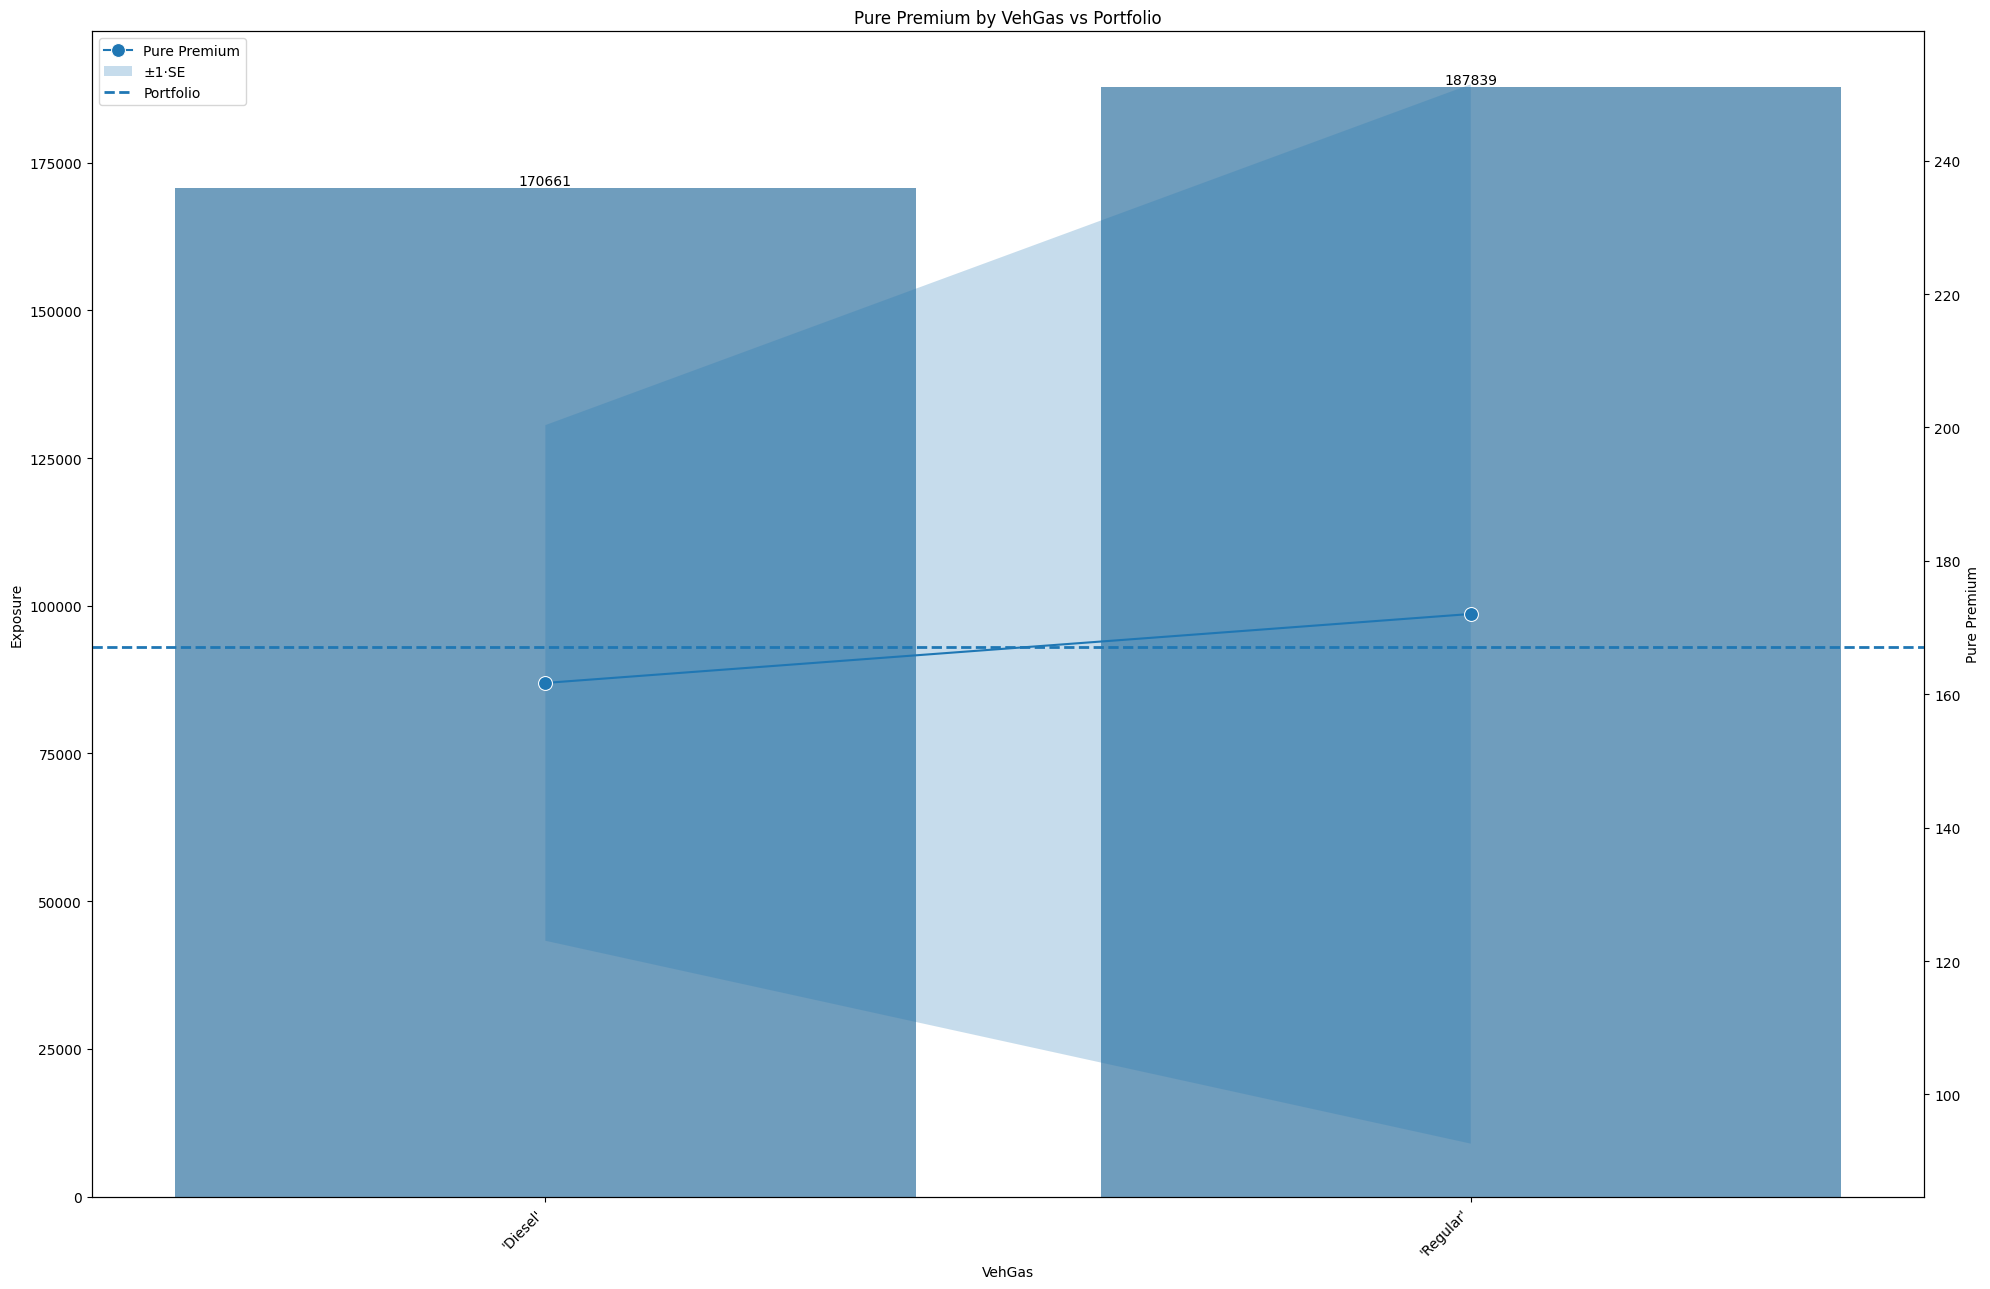

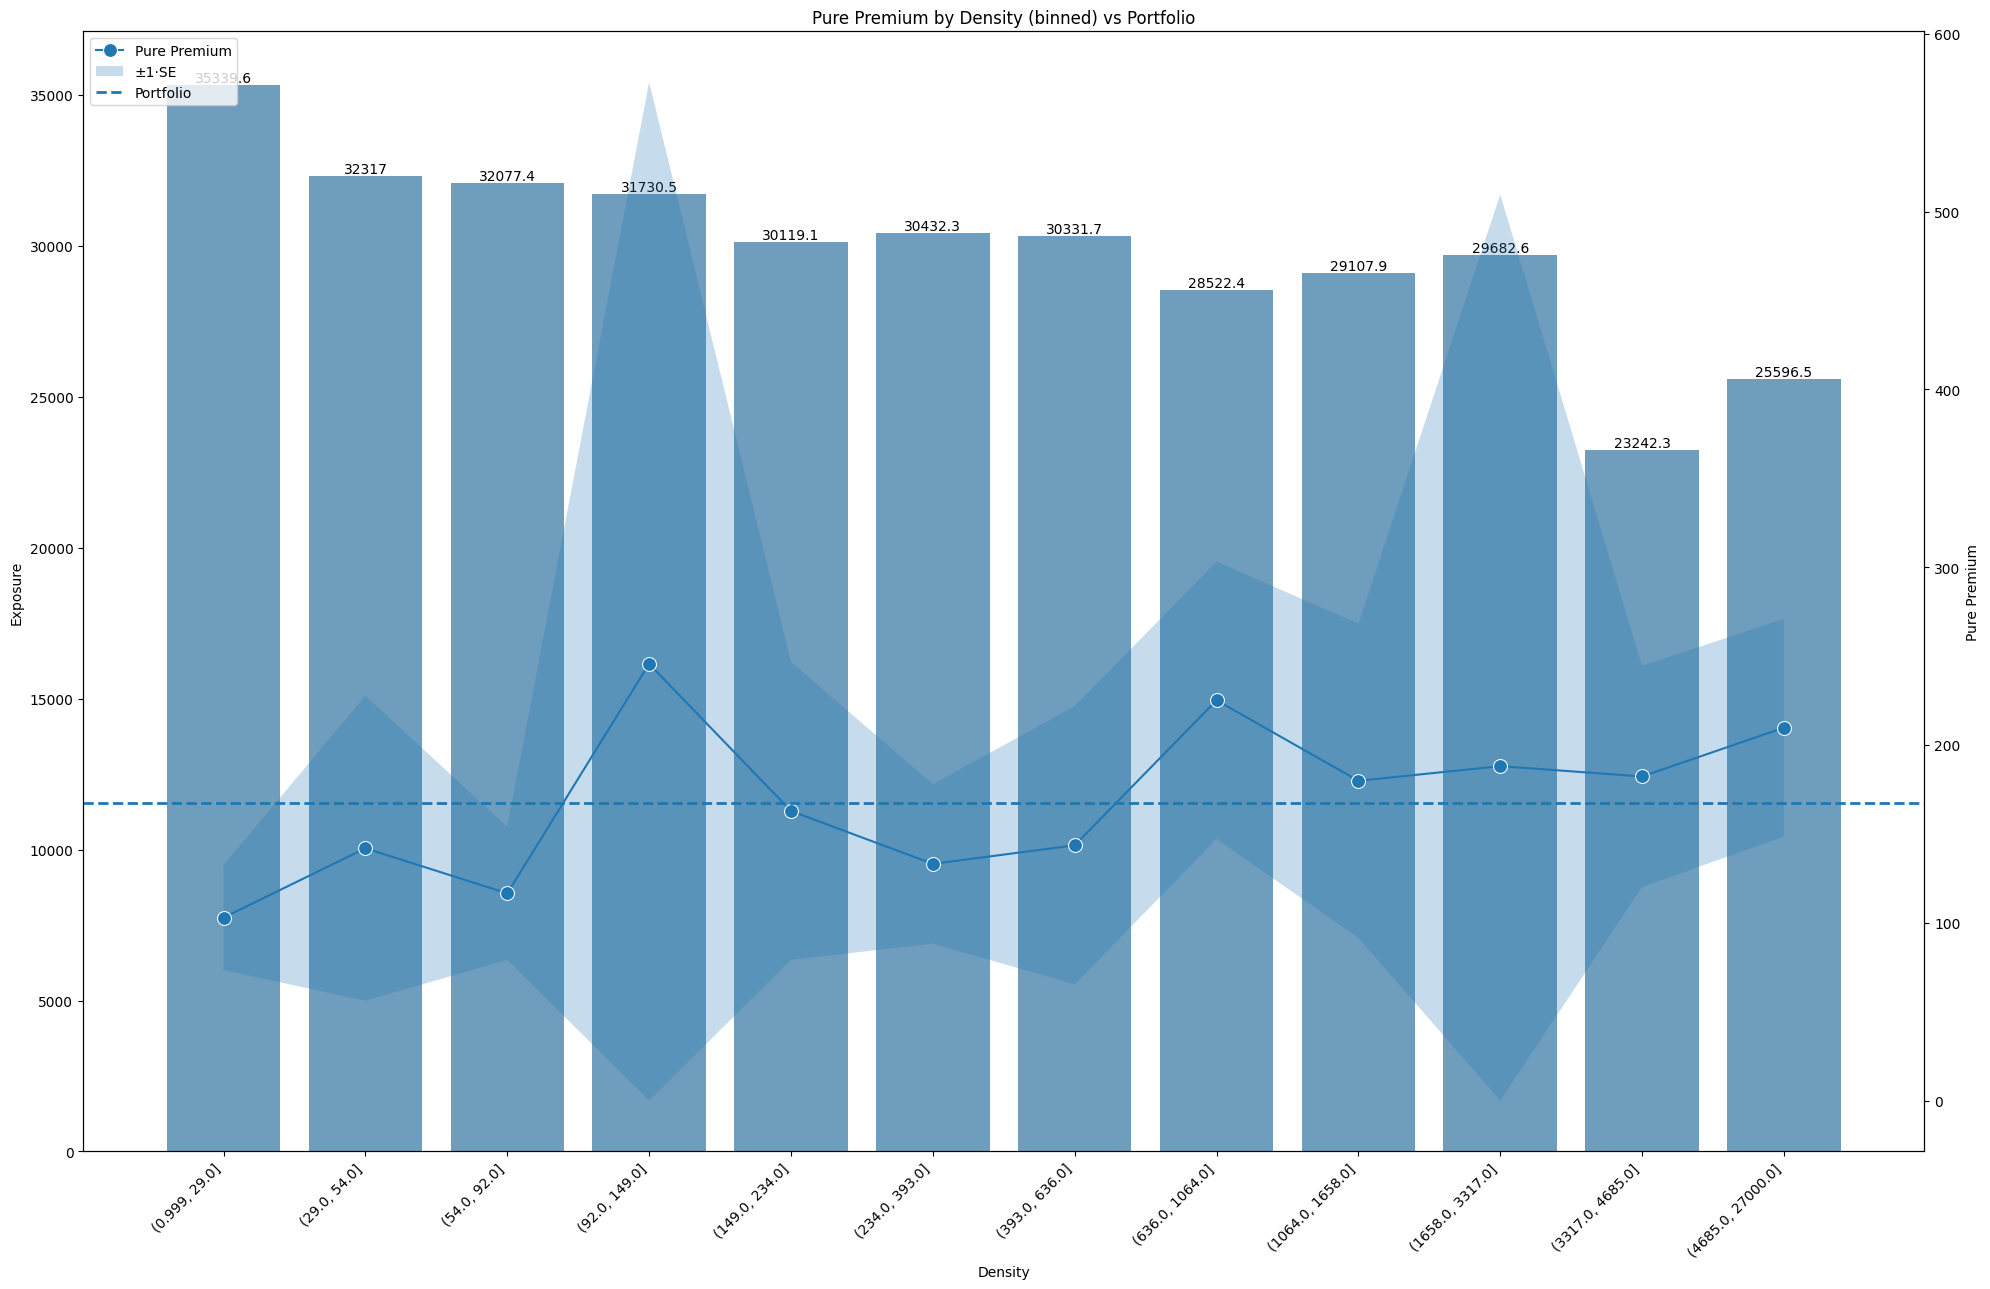

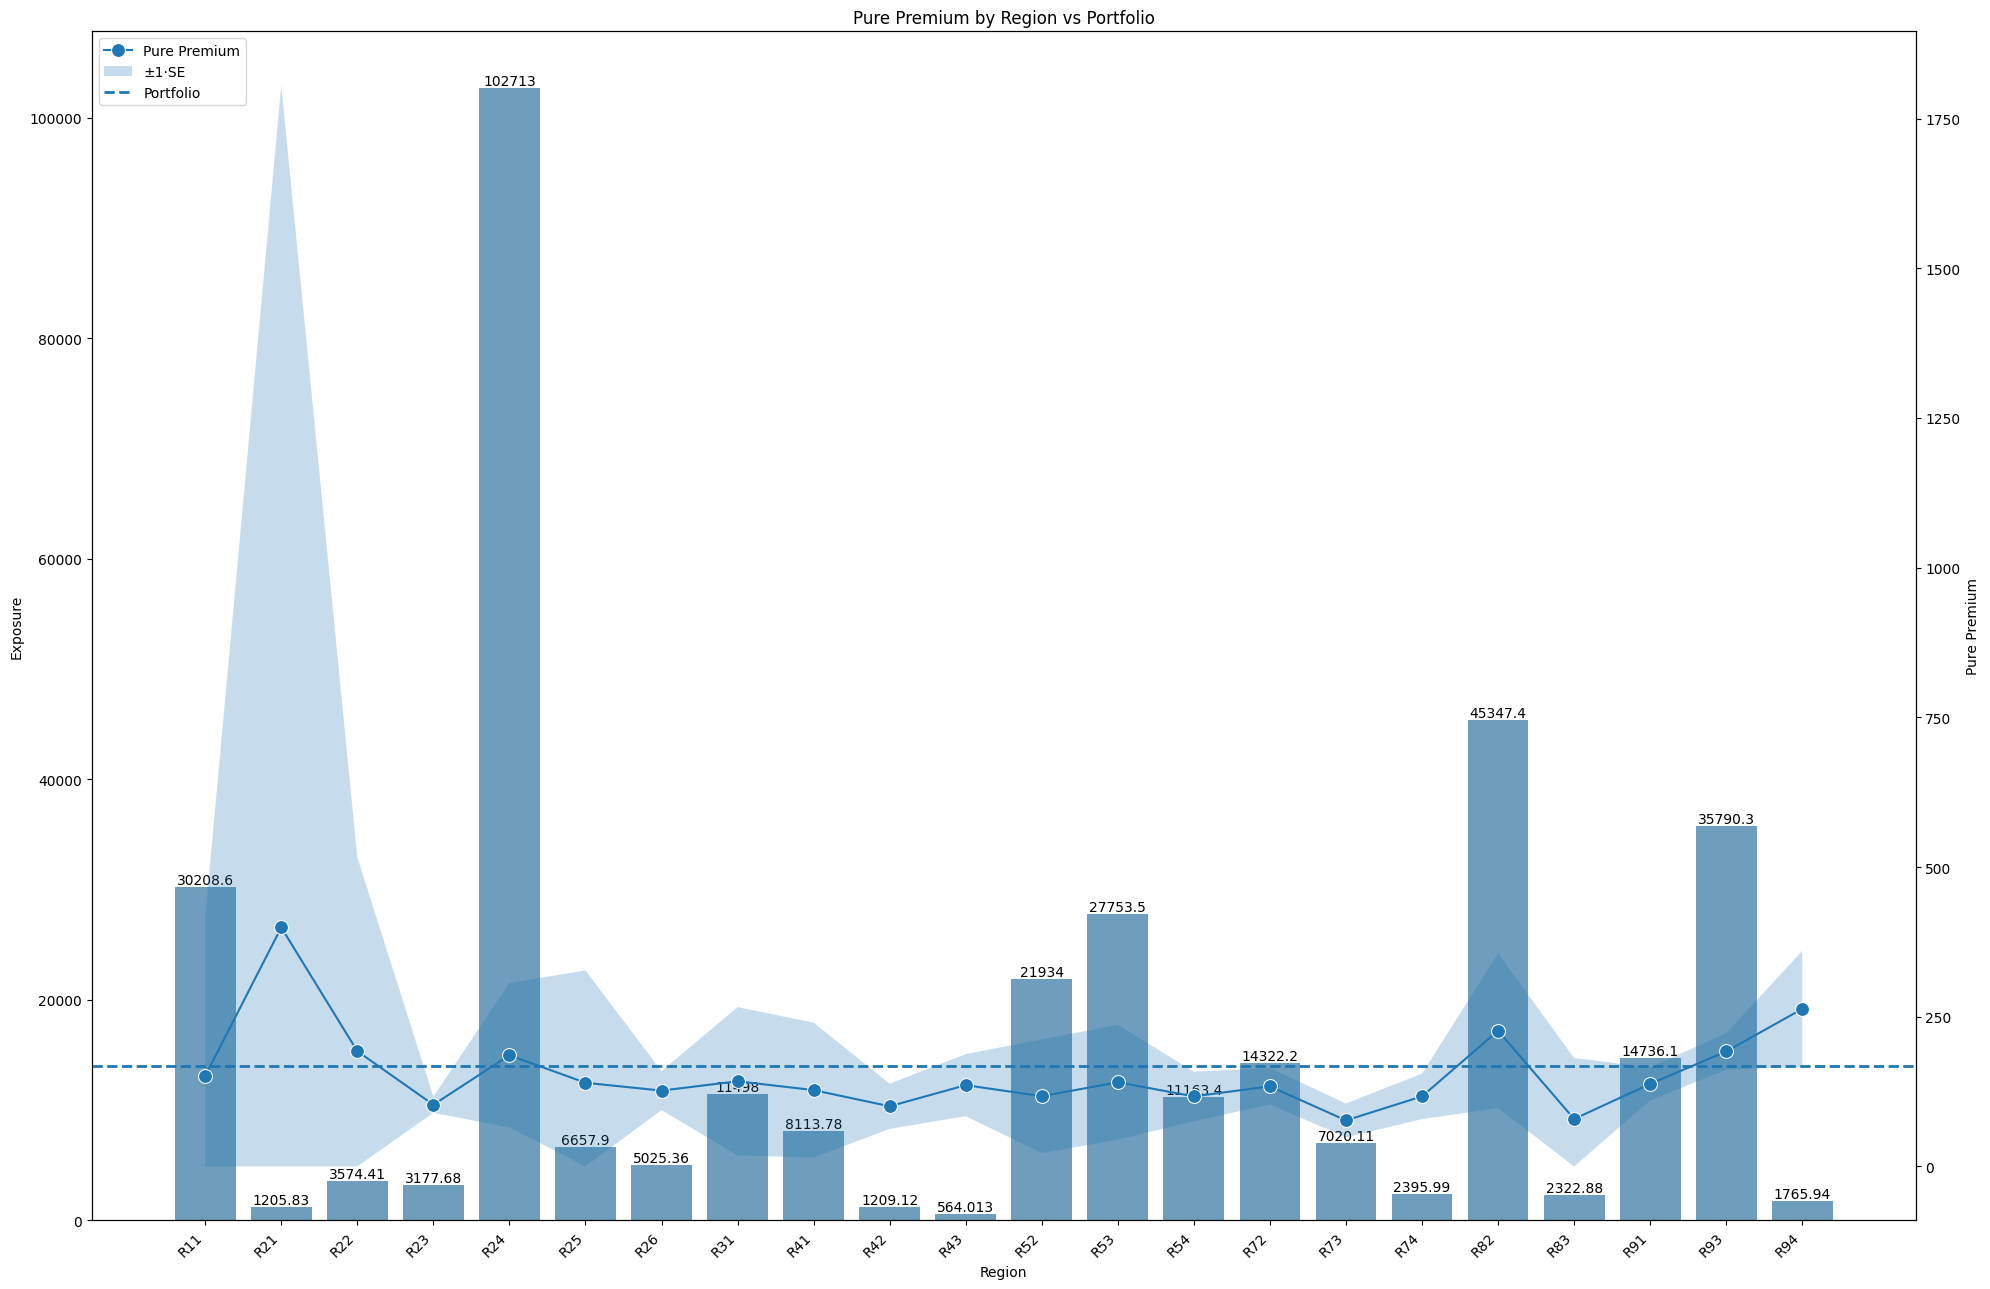

In [8]:
for col in X_cols:
  fig = runmultiplot(df, col, metric="Pure Premium")

Some thoughts after the above graphs:

- Things generally look decent. There's not an enormous amount of variability obvious in the charts, but I'd argue that's because of the y-axis scaling with the +/- 1 SE on it.
- Many of the categorical variables contain bins with very little exposure in it: Region, VehBrand, Area. I'll need to stay aware of those.
- Many of the numeric variables will NOT be handled well if I just fit a straight-line to it. BonusMalus for example is quite quadratic in shape. I'll need to consider this before constructing a model.
- Most of the numeric variables have some skewness issues. I can see extremely large or small values making the left or right-most bins *really* large in width.

These aren't bad things! I just need to keep these things in mind during the model building process.

# 2-Way Analysis

I'll do a quick 2-way linear correlation analysis on the numeric variables. 

Couples things:

- This does not cover correlation with categorical variables
- This does not cover non-linear correlation

This is a *very* simple and limited view. I'm mainly checking for extreme multicollinearity. I have other more advanced techniques for detecting and dealing with this in other notebooks.

<Axes: >

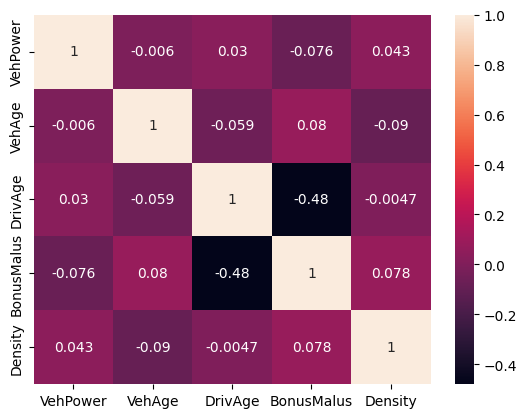

In [9]:
cols = [
  'VehPower',
  'VehAge',
  'DrivAge',
  'BonusMalus',
  'Density',
]
sns.heatmap(df[cols].corr(), annot=True)

Generally speaking, most variables aren't tremendously correlated with each other except for BonusMalus and DrivAge. This isn't surprising- BonusMalus is a prior claims history variable. It makes sense that younger ages have worse prior driving experience. 

Again- no problems here. I just have to be aware there is a bit of correlation going on in these two variables.

# Train/Test Split

Before I go ANY further, it is important that I split this data into train and test. I've already done some basic exploratory data analysis and "peeking" at what should be some independent holdout data that I'll use later for model analysis. I haven't made any big decisions or anything, so I'm not in huge trouble.

But I need to split before I do anything further.

I want to split into a random, but stratified 80% train and 20% test split. The strata is frequency. I want the same overall claims frequency level in both splits. I've made a rather complicated function for this that I'll use.

The test data will be *strictly* ignored all the way until the very end of my modeling exercises and *never* seen by the model or used in my decision-making. This will make the test data a truly independent holdout to objectively benchmark and compare my different modeling techniques in the project.

In [10]:
df = stratified_split_match_portfolio_freq(
    df,
    group_col="IDpol",
    exposure_col="Exposure",
    claim_col="ClaimNb",
    test_size=0.20,
    q=10,
    tol=0.002,
    max_tries=300,
    random_state=42
)

df_train = df[df['set'] == 'train'].copy()
df_test = df[df['set'] == 'test'].copy()

Used seed: 42 | bins: has_claim
Overall PF: 0.100703
Train PF  : 0.100618
Test  PF  : 0.101044
|Train-Test|: 0.000426 (tol=0.002)


# Export Data

In [ ]:
# starting sets in case OpenML ever loses them
df_raw_freq.to_parquet("data/df_raw_freq.parquet")
df_raw_sev.to_parquet("data/df_raw_sev.parquet")

# train and test
df_train.to_parquet("data/df_train.parquet")
df_test.to_parquet("data/df_test.parquet")

# Conclusions & Next Step

Okay so to recap, in this document I've:

1) Imported my data
2) Did some basic preprocessing and added a few capping scenarios
3) Explored my data through simple 1 and 2-way analysis
4) Created a logical train/test split and saved the files locally

I mentioned above that there was at least one (perhaps more) unreasonably large individual claim amounts. That is my next step in the process. I want to determine the best level to cap my target variable at.